Select allergies by number (comma-separated):
abc 0: Alcohol Allergy
abc 1: Allium Allergy
abc 2: Alpha-gal Syndrome
abc 3: Aquagenic Urticaria
abc 4: Banana Allergy
abc 5: Broccoli Allergy
abc 6: Citrus Allergy
abc 7: Cocoa Allergy
abc 8: Coconut Allergy
abc 9: Corn Allergy
abc 10: Cruciferous Allergy
abc 11: Fish Allergy
abc 12: Gluten Allergy
abc 13: Hazelnut Allergy
abc 14: Histamine Allergy
abc 15: Honey Allergy
abc 16: Hypersensitivity
abc 17: Insulin Allergy
abc 18: LTP Allergy
abc 19: Legume Allergy
abc 20: Milk Allergy / Lactose Intolerance
abc 21: Mint Allergy
abc 22: Mushroom Allergy
abc 23: Nightshade Allergy
abc 24: Nut Allergy
abc 25: Ochratoxin Allergy
abc 26: Oral Allergy Syndrome
abc 27: Peanut Allergy
abc 28: Pepper Allergy
abc 29: Pinenut Allergy
abc 30: Potato Allergy
abc 31: Poultry Allergy
abc 32: Ragweed Allergy
abc 33: Rice Allergy
abc 34: Salicylate Allergy
abc 35: Seed Allergy
abc 36: Shellfish Allergy
abc 37: Soy Allergy
abc 38: Stone Fruit Allergy
abc 39: Su

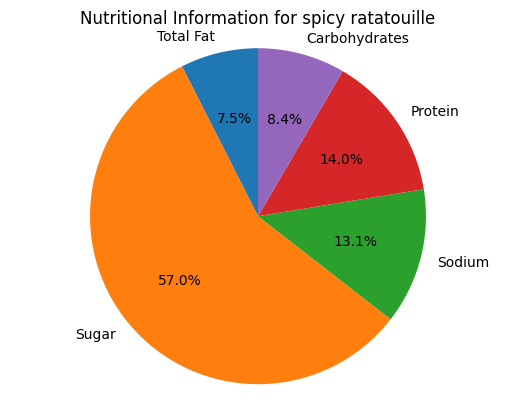

In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to preprocess data
def preprocess_data(df):
    df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = df['nutrition'].str.split(",", expand=True)
    df['calories'] = df['calories'].apply(lambda x: x.replace('[',''))
    df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].apply(lambda x: x.replace(']',''))
    df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']].astype('float')
    df.drop(['tags', 'nutrition', 'contributor_id', 'submitted'], axis=1, inplace=True)

    df['food types'] = np.nan
    df['food types'] = df['food types'].astype('str')

    for i in df.index:
        if 'eggs' not in df.loc[i, 'ingredients']:
            if 'ice-cream' in df.loc[i, 'ingredients'] or 'chocolate' in df.loc[i, 'ingredients'] or 'cookies' in df.loc[i, 'ingredients']:
                df.loc[i, 'food types'] = 'dessert with egg'
        elif 'eggs' in df.loc[i, 'ingredients']:
            if 'ice-cream' in df.loc[i, 'ingredients'] or 'chocolate' in df.loc[i, 'ingredients'] or 'cookies' in df.loc[i, 'ingredients']:
                df.loc[i, 'food types'] = 'Non-Egg dessert'

    for i in df.index:
        if df.loc[i, 'food types'] != 'dessert with egg' and df.loc[i, 'food types'] != 'Non-Egg dessert' and df.loc[i, 'food types'] != 'Healthy':
            if 'chicken' in df.loc[i, 'ingredients'] or 'eggs' in df.loc[i, 'ingredients'] or 'ham' in df.loc[i, 'ingredients'] or 'pepperoni' in df.loc[i, 'ingredients']:
                df.loc[i, 'food types'] = 'Non-veg'

    for i in df.index:
        if df.loc[i, 'food types'] != 'dessert with egg' and df.loc[i, 'food types'] != 'Non-Egg dessert' and df.loc[i, 'food types'] != 'Healthy' and df.loc[i, 'food types'] != 'Non-veg':
            df.loc[i, 'food types'] = 'Veg'

    return df

# Function to select allergies and combine foods
def select_allergies_and_combine_foods(allergies_list_df, recipes_df):
    # Display the list of allergies
    print("Select allergies by number (comma-separated):")
    for idx, allergy in enumerate(allergies_list_df['Allergy']):
        print(f"abc {idx}: {allergy}")

    # Get user input
    selections = input("Enter the numbers of the allergies you have: ")
    selected_indices = list(map(int, selections.split(',')))

    # Create a temporary list to store combined foods
    combined_foods = []

    # Collect foods from selected allergies
    for idx in selected_indices:
        if 0 <= idx < len(allergies_list_df):
            combined_foods.extend(allergies_list_df.loc[idx, 'Food'])
        else:
            print(f"Index {idx} is out of range. Skipping...")

    # Remove duplicates and print the combined list
    combined_foods = list(set(combined_foods))
    print("\nCombined food list for selected allergies:")
    print(combined_foods)

    # Function to check if any food in combined_foods is in the ingredients using NLP
    def contains_foods(ingredients, foods):
        ingredients_doc = nlp(ingredients.lower())
        ingredient_tokens = set(token.lemma_ for token in ingredients_doc if not token.is_stop and not token.is_punct)

        for food in foods:
            food_doc = nlp(food.lower())
            food_tokens = set(token.lemma_ for token in food_doc if not token.is_stop and not token.is_punct)
            if food_tokens & ingredient_tokens:  # Check if there's any overlap
                return True
        return False

    # Apply the function to each row in recipes_df
    recipes_df['Contains_Selected_Foods'] = recipes_df['ingredients'].apply(lambda x: contains_foods(x, combined_foods))

    return recipes_df

# Function to calculate calorie limits
def calculate_calorie_limits():
    welcome()
    gender = get_gender()
    weight = get_weight()
    height = get_height()
    age = get_age()
    rest_bmr = calculate_bmr(gender, weight, height, age)
    user_activity_lvl = get_user_activity()
    tdee = calculate_tdee(rest_bmr, user_activity_lvl)
    goal = get_goal()
    upper_calories = recommend_calories(tdee, goal)
    return calculate_meal_distribution(upper_calories)

def welcome():
    print("Welcome to your calories python calculator!\nFind out how many calories you should eat daily based on your goals.\n")

def get_gender():
    gender_options = ["male", "female", "m", "f"]
    while True:
        gender = input("Please enter your gender (male/female): ").strip().lower()
        if gender not in gender_options:
            print("Invalid input. Please enter either 'male' or 'female'.")
        else:
            return gender

def get_weight():
    while True:
        try:
            weight_kg = float(input("Enter your weight in kilograms: "))
            if weight_kg > 0:
                return weight_kg
            else:
                print("Weight must be a positive number.")
        except ValueError:
            print("Invalid input. Please enter a valid number for weight.")

def get_height():
    while True:
        try:
            height_cm = float(input("Enter your height in centimeters: "))
            if height_cm > 0:
                return height_cm
            else:
                print("Height must be a positive number.")
        except ValueError:
            print("Invalid input. Please enter a valid number for height.")

def get_age():
    while True:
        try:
            age_yrs = int(input("Enter your age in years: "))
            if age_yrs > 0:
                return age_yrs
            else:
                print("Age must be a positive number.")
        except ValueError:
            print("Invalid input. Please enter a valid number for age.")

def calculate_bmr(gender, weight, height, age):
    if gender in ["female", "f"]:
        return (10 * weight) + (6.25 * height) - (5 * age) - 161
    else:
        return (10 * weight) + (6.25 * height) - (5 * age) + 5

def get_user_activity():
    activity_levels = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725,
        "extremely active": 1.9
    }
    while True:
        user_lvl = input("\nWhat is your activity level?\n"
                         "Sedentary: little to no exercise.\n"
                         "Lightly active: light exercise/sports 1-3 days/week.\n"
                         "Moderately active: moderate exercise/sports 3-5 days/week.\n"
                         "Very active: hard exercise every day or 2x/day 6-7 days/week.\n"
                         "Extremely active: very hard exercise, physically demanding job, or training twice a day.\n"
                         "Please enter: 'sedentary', 'light', 'moderate', 'active', or 'extremely active': ").strip().lower()
        if user_lvl in activity_levels:
            return activity_levels[user_lvl]
        else:
            print("Invalid input. Please enter a valid activity level.")

def calculate_tdee(bmr, activity_factor):
    return bmr * activity_factor

def get_goal():
    goals = ["maintain", "lose", "gain"]
    while True:
        goal = input("\nWhat is your goal?\n"
                     "Maintain: Maintain your current weight.\n"
                     "Lose: Lose weight.\n"
                     "Gain: Gain weight.\n"
                     "Please enter 'maintain', 'lose', or 'gain': ").strip().lower()
        if goal in goals:
            return goal
        else:
            print("Invalid input. Please enter 'maintain', 'lose', or 'gain'.")

def recommend_calories(tdee, goal):
    if goal == "maintain":
        calories = int(tdee)
        print(f"To maintain your current weight, you should consume around {calories} calories per day.")
    elif goal == "lose":
        calories = int(tdee - 500)
        print(f"To lose weight, you should consume between {int(tdee - 750)} and {calories} calories per day.")
    elif goal == "gain":
        calories = int(tdee + 500)
        print(f"To gain weight, you should consume between {int(tdee + 250)} and {calories} calories per day.")

    return calories

def calculate_meal_distribution(calories):
    breakfast = calories * 0.2
    lunch = calories * 0.34
    dinner = calories * 0.34
    snacks = calories * 0.11

    print("\nBased on your goal, here is the recommended calorie distribution for your meals:")
    print(f"Breakfast: {int(breakfast)} calories")
    print(f"Lunch: {int(lunch)} calories")
    print(f"Dinner: {int(dinner)} calories")
    print(f"Snacks: {int(snacks)} calories")

    return {
        "breakfast": int(breakfast),
        "lunch": int(lunch),
        "dinner": int(dinner),
        "snacks": int(snacks)
    }

# Function to filter recipes based on food type preference and calorie limit
def filter_recipes_by_preference_and_calories(recipes_df, preference, meal_type, calorie_limit):
    filtered_recipes = recipes_df[
        (recipes_df['food types'] == preference) &
        (recipes_df['calories'] <= calorie_limit) &
        (recipes_df['Contains_Selected_Foods'] == False)
    ]

    return filtered_recipes

# Function to recommend food options based on preferences and calorie limits
def recommend_food_options(calorie_limits, recipes_df):
    preferences = ["Veg", "Non-veg"]
    meal_types = ["breakfast", "lunch", "dinner", "snacks"]

    preference = input("Do you prefer 'Veg' or 'Non-veg' options? ").strip()
    if preference not in preferences:
        print("Invalid preference. Defaulting to 'Veg'.")
        preference = "Veg"

    meal_type = input("Which meal do you want recommendations for (breakfast, lunch, dinner, snacks)? ").strip()
    if meal_type not in meal_types:
        print("Invalid meal type. Defaulting to 'breakfast'.")
        meal_type = "breakfast"

    filtered_recipes = filter_recipes_by_preference_and_calories(recipes_df, preference, meal_type, calorie_limits[meal_type])

    recommendation_count = 5
    start = 0

    while start < len(filtered_recipes):
        print(f"\nRecommended {preference} options for {meal_type} (calories <= {calorie_limits[meal_type]}):")
        for i, (index, row) in enumerate(filtered_recipes.iloc[start:start+recommendation_count].iterrows()):
            print(f"{start + i + 1}. {row['name']} ({row['calories']} calories)")

        more_recommendations = input("Do you need more recommendations? (yes/no): ").strip().lower()
        if more_recommendations == 'no':
            break
        start += recommendation_count

    while True:
        try:
            option_number = int(input("Enter the number of the dish you prefer: "))
            if 1 <= option_number <= len(filtered_recipes):
                selected_row = filtered_recipes.iloc[option_number - 1]
                print(f"\nOption {option_number}:")
                print(f"Name: {selected_row['name']}")
                print(f"Minutes: {selected_row['minutes']}")
                print(f"Number of Steps: {selected_row['n_steps']}")
                print(f"Steps: {eval(selected_row['steps'])[0]}")
                print(f"Description: {selected_row['description']}")
                print(f"Ingredients: {selected_row['ingredients']}")
                print(f"Number of Ingredients: {selected_row['n_ingredients']}")
                print(f"Calories: {selected_row['calories']}")
                print(f"Total Fat (PDV): {selected_row['total fat (PDV)']}")
                print(f"Sugar (PDV): {selected_row['sugar (PDV)']}")
                print(f"Sodium (PDV): {selected_row['sodium (PDV)']}")
                print(f"Protein (PDV): {selected_row['protein (PDV)']}")
                print(f"Saturated Fat (PDV): {selected_row['saturated fat (PDV)']}")
                print(f"Carbohydrates (PDV): {selected_row['carbohydrates (PDV)']}")

                fig, ax = plt.subplots()
                nutritional_data = [
                    selected_row.loc['total fat (PDV)'],
                    selected_row.loc['sugar (PDV)'],
                    selected_row.loc['sodium (PDV)'],
                    selected_row.loc['protein (PDV)'],
                    selected_row.loc['carbohydrates (PDV)']
                ]
                nutritional_labels = ['Total Fat', 'Sugar', 'Sodium', 'Protein', 'Carbohydrates']
                plot_pie_chart(ax, nutritional_data, nutritional_labels)

                plt.title(f"Nutritional Information for {selected_row['name']}")
                plt.show()
                break
            else:
                print("Invalid number. Please enter a valid dish number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def plot_pie_chart(ax, data, labels):
    ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')

def main():
    # Load the dataset
    df = pd.read_csv('RAW_recipes.csv')
    recipes_df = df.sample(n=5000)
    allergies_df = pd.read_excel('food ingredients and allergens.xlsx')

    # Convert 'Food' to lowercase first
    allergies_df['Food'] = allergies_df['Food'].str.lower()

    # Group and aggregate the foods by allergy
    allergies_list_df = allergies_df.groupby('Allergy')['Food'].apply(list).reset_index()

    # allergies_list_df =['cream', 'egg', 'sour cream', 'mascarpone cheese', 'heavy cream', 'goat cheese', 'parmesan cheese', 'butter', 'buttermilk', 'duck', 'ghee', 'whey', 'mozzarella cheese', 'cheese', 'chicken', 'yogurt', 'custard', 'ice cream', 'whipped cream', 'milk', 'turkey', 'casein']

    # Preprocess the data
    recipes_df = preprocess_data(recipes_df)

    # Select allergies and combine foods
    recipes_df = select_allergies_and_combine_foods(allergies_list_df, recipes_df)

    # Calculate calorie limits
    calorie_limits = calculate_calorie_limits()

    # Recommend food options based on preferences and calorie limits
    recommend_food_options(calorie_limits, recipes_df)

if __name__ == '__main__':
    main()
